# Project Pertama: Membuat model NLP dengan TensorFlow
---
---
* Nama: Benjamin Nikholas
* Email: benjisturi@gmail.com
* Nomor Telp : [6287892677303](wa.me/6287892677303)

Kriteria Parameter:
1. Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.
2. Harus menggunakan LSTM dalam arsitektur model.
3. Harus menggunakan model sequential.
4. Validation set sebesar 20% dari total dataset.
5. Harus menggunakan Embedding.
6. Harus menggunakan fungsi tokenizer.
7. Akurasi dari model minimal 75% pada train set dan validation set.

---

Kriteria target nilai sempurna **(bintang 5)**:
1. dataset memiliki 3 kelas atau lebih
2. dataset memiliki minimal 2000 sampel data
3. akurasi pada training set dan validation set
4. Mengimplementasikan Callback
5. Membuat plot loss dan akurasi pada saat training dari validation set

In [30]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
import tensorflow as tf
from tensorflow.keras import Sequential, layers, regularizers, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")
plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [3]:
# Check data info

df_movies = pd.read_csv('/content/imdb_movies.csv')
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   names       10178 non-null  object 
 1   date_x      10178 non-null  object 
 2   score       10178 non-null  float64
 3   genre       10093 non-null  object 
 4   overview    10178 non-null  object 
 5   crew        10122 non-null  object 
 6   orig_title  10178 non-null  object 
 7   status      10178 non-null  object 
 8   orig_lang   10178 non-null  object 
 9   budget_x    10178 non-null  float64
 10  revenue     10178 non-null  float64
 11  country     10178 non-null  object 
dtypes: float64(3), object(9)
memory usage: 954.3+ KB


In [4]:
# Checking and Dropping columns with NaN

for cols in df_movies.columns:

  # Count value on each column with no NaN value
  data_length = len(df_movies[cols].dropna())

  # Drop Columns with incomplete data/value (NaN)
  if data_length != len(df_movies):
    print(cols)
    df_movies.drop(cols, axis = 1, inplace = True)

df_movies.info()

genre
crew
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   names       10178 non-null  object 
 1   date_x      10178 non-null  object 
 2   score       10178 non-null  float64
 3   overview    10178 non-null  object 
 4   orig_title  10178 non-null  object 
 5   status      10178 non-null  object 
 6   orig_lang   10178 non-null  object 
 7   budget_x    10178 non-null  float64
 8   revenue     10178 non-null  float64
 9   country     10178 non-null  object 
dtypes: float64(3), object(7)
memory usage: 795.3+ KB


In [5]:
# Initialize random number generator to ensure reproducibility

def SetSeed(seed:int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    check_random_state(seed)

In [6]:
for i in df_movies.columns:
  print(f'unique values on {i} : {len(df_movies[i].unique())}')
  if len(df_movies[i].unique()) < 10:
    print(df_movies[i].unique())

unique values on names : 9660
unique values on date_x : 5688
unique values on score : 79
unique values on overview : 9905
unique values on orig_title : 9736
unique values on status : 3
[' Released' ' Post Production' ' In Production']
unique values on orig_lang : 54
unique values on budget_x : 2316
unique values on revenue : 8227
unique values on country : 60


In [7]:
df_movie_status = df_movies[['names','status']]
df_movie_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   names   10178 non-null  object
 1   status  10178 non-null  object
dtypes: object(2)
memory usage: 159.2+ KB


In [8]:
# Check new dataframe

df_status = pd.get_dummies(df_movies.status)
df_movies = pd.concat([df_movie_status, df_status], axis = 1)
df_movies.drop(columns = 'status', inplace = True)
df_movies

,names,In Production,Post Production,Released
0,Creed III,0,0,1
1,Avatar: The Way of Water,0,0,1
2,The Super Mario Bros. Movie,0,0,1
3,Mummies,0,0,1
4,Supercell,0,0,1
...,...,...,...,...
10173,20th Century Women,0,0,1
10174,Delta Force 2: The Colombian Connection,0,0,1
10175,The Russia House,0,0,1
10176,Darkman II: The Return of Durant,0,0,1


In [9]:
# Membagi data menjadi train (80%) dan validation (20%)
X = df_movies['names'].values
y = df_movies.iloc[:, 1:].values

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  train_size = 0.8,
                                                  random_state = 10)

### Tokenizer

In [16]:
tokenizer = Tokenizer(num_words = 5000, oov_token = 'X')

# Fit tokenizer on text data
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_val)

# Implement Tokenization on train dan validation data
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_val_tokenized = tokenizer.texts_to_sequences(X_val)

### Padding Sequence

In [19]:
max_length = 20
X_train_padded = pad_sequences(X_train_tokenized,
                               maxlen = max_length)

X_val_padded = pad_sequences(X_val_tokenized,
                             maxlen = max_length)

### LSTM Model

In [28]:
# LSTM Model

SetSeed(2024)

model = Sequential([

    # Add Embedding layer
    layers.Embedding(input_dim = 5000,
                     output_dim = 16),

    # Add LSTM Layer
    layers.LSTM(units = 64),
    layers.Dropout(0.2),

    # Add Fully Connected Layer
    layers.Dense(units = 128,
                 activation = 'relu',
                 kernel_regularizer = regularizers.l2(0.01)),
    layers.Dense(units = 128,
                 activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(units = 3,
                 activation = 'softmax'),
])

In [31]:
# Compiling model

SetSeed(2024)

# AMSGrad Optimizer
AMSGrad = optimizers.Adam(amsgrad = True, name = 'Adam')

model.compile(loss = 'categorical_crossentropy',
              metrics = 'accuracy',
              optimizer = AMSGrad)

In [32]:
# Callbacks implementation

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    verbose = 2,
    patience = 5,
    restore_best_weights = True,
    mode = 'min'
)

In [33]:
# Model Fitting

SetSeed(2024)

model_fit = model.fit(X_train_padded, y_train,
                      epochs = 50,
                      validation_data = (X_val_padded, y_val),
                      verbose = 2,
                      callbacks = EarlyStop)

Epoch 1/50
255/255 - 7s - loss: 0.3159 - accuracy: 0.9942 - val_loss: 0.0488 - val_accuracy: 0.9961 - 7s/epoch - 27ms/step
Epoch 2/50
255/255 - 4s - loss: 0.0469 - accuracy: 0.9952 - val_loss: 0.0333 - val_accuracy: 0.9961 - 4s/epoch - 14ms/step
Epoch 3/50
255/255 - 3s - loss: 0.0419 - accuracy: 0.9952 - val_loss: 0.0295 - val_accuracy: 0.9961 - 3s/epoch - 12ms/step
Epoch 4/50
255/255 - 3s - loss: 0.0391 - accuracy: 0.9952 - val_loss: 0.0305 - val_accuracy: 0.9961 - 3s/epoch - 12ms/step
Epoch 5/50
255/255 - 4s - loss: 0.0342 - accuracy: 0.9952 - val_loss: 0.0304 - val_accuracy: 0.9961 - 4s/epoch - 16ms/step
Epoch 6/50
255/255 - 3s - loss: 0.0264 - accuracy: 0.9952 - val_loss: 0.0352 - val_accuracy: 0.9961 - 3s/epoch - 13ms/step
Epoch 7/50
255/255 - 3s - loss: 0.0197 - accuracy: 0.9952 - val_loss: 0.0461 - val_accuracy: 0.9961 - 3s/epoch - 12ms/step
Epoch 8/50
Restoring model weights from the end of the best epoch: 3.
255/255 - 3s - loss: 0.0161 - accuracy: 0.9952 - val_loss: 0.0463 - v

In [34]:
# Check model fitting history data

model_history = pd.DataFrame(model_fit.history)
model_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          8 non-null      float64
 1   accuracy      8 non-null      float64
 2   val_loss      8 non-null      float64
 3   val_accuracy  8 non-null      float64
dtypes: float64(4)
memory usage: 384.0 bytes


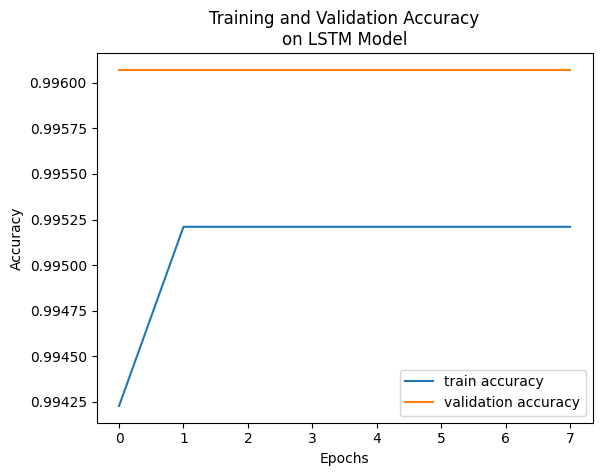

In [35]:
# Accuracy Plot on Training and Validation

plt.plot(model_history.accuracy, label = 'train accuracy')
plt.plot(model_history.val_accuracy, label = 'validation accuracy')
plt.title('Training and Validation Accuracy\non LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

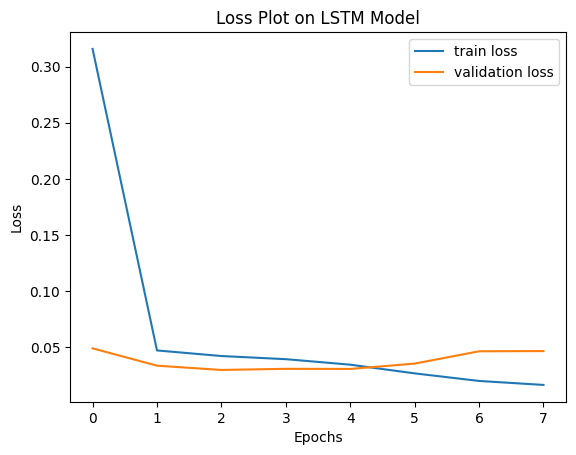

In [36]:
# Loss Plot on Training and Validation data

plt.plot(model_history.loss, label = 'train loss')
plt.plot(model_history.val_loss, label = 'validation loss')
plt.title('Loss Plot on LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [39]:
# Check accuracy on training and validation data

min_accuracy = 0.75 # 75%

print(f'''Training data accuracy pass 75% : {model_history.accuracy.max() > min_accuracy}
Validation data accuracy pass 75% : {model_history.val_accuracy.max() > min_accuracy}''')

Training data accuracy pass 75% : True
Validation data accuracy pass 75% : True
